# Adjectieven
## Details
> Adjectieven geven meer duiding bij een onderwerp. Adjectieven  in  koppen  worden  vaak  gebruikt  om gevoelens bij de lezers los te maken:  adjectieven in krantenkoppen  kunnen  fungeren  als  versterkers  en zorgen voor meer inleving van de lezers.

## Example
> GokverslaafdeJaak (32) klapt uit de biecht: “Ik heb het geld voor mijn bouwgrond vergokt”Vs. Jaak(32) was verslaafd aan gokken, en praat voor het eerst over de donkerste periode uit zijn leven


## Data

In [1]:
from util import get_cls_train_test

train_x, train_y, test_x, test_y = get_cls_train_test("Adjectieven")
train_y.value_counts()

0    521
1    160
Name: Adjectieven, dtype: int64

## Approach 1: Tf-idf
With tf-idf or just a count vectorizer, we might already achieve quite a good result, since it just needs to learn some adjectives.

f-score: 0.1764705882352941
Confusion matrix: (TP: 166, FP: 10, FN: 46, TN: 6)
Accuracy=75.44% (172/228)


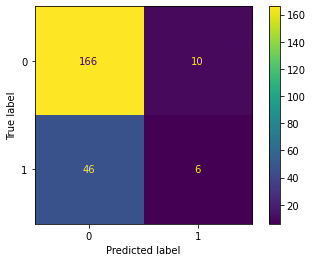

In [2]:
from imblearn.pipeline import Pipeline
from imblearn.combine import SMOTETomek
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import svm

from util import fit_predict_evaluate

model = Pipeline([
    ('vectorizer', TfidfVectorizer()),
    ('resampler', SMOTETomek(random_state=0)),
    ('classifier', svm.LinearSVC(random_state=0))
])

fit_predict_evaluate(model, train_x, train_y, test_x, test_y)

In [3]:
from util import show_most_informative_features
show_most_informative_features(model)

1.1994         turkse    -1.2209           zijn
1.1936         lelijk    -1.1422            wat
1.1528         triest    -0.9559             nu
1.1410           kans    -0.9504           niet
1.1376          jonge    -0.8988             ik
1.1292       vergeten    -0.8766            was
1.0779   schaamteloze    -0.8196          eigen
1.0695             vs    -0.8102            met
1.0572          slaat    -0.7898           hier
1.0389           mike    -0.7794             in


The positive terms are as expected mainly adjectives (but also some other strange words like "kns", "vs", "slaat" and "mike"). "Zijn" is probably an important negative, because words aren't an adjective then but an adverb.

f-score: 0.3770491803278688
Confusion matrix: (TP: 129, FP: 47, FN: 29, TN: 23)
Accuracy=66.67% (152/228)


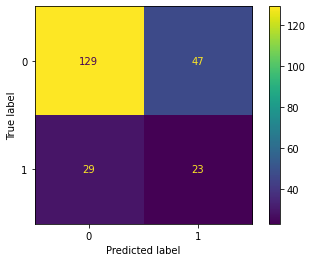

In [4]:
from sklearn.feature_extraction.text import CountVectorizer

model = Pipeline([
    ('vectorizer', CountVectorizer()),
    ('resampler', SMOTETomek(random_state=0)),
    ('classifier', svm.LinearSVC(random_state=0))
])

fit_predict_evaluate(model, train_x, train_y, test_x, test_y)

This gives a higher accuracy and a lower test score, but still no good results.

## Approach 2: Stemmer

f-score: 0.18918918918918917
Confusion matrix: (TP: 161, FP: 15, FN: 45, TN: 7)
Accuracy=73.68% (168/228)


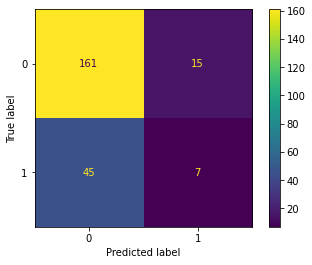

In [5]:
from util import stem_analyzer

model = Pipeline([
    ('vectorizer', TfidfVectorizer(analyzer=stem_analyzer)),
    ('resampler', SMOTETomek(random_state=0)),
    ('classifier', svm.LinearSVC(random_state=0))
])

fit_predict_evaluate(model, train_x, train_y, test_x, test_y)

This resulted in similar results. A possiblity for lower accuracy might be that some adjectives can share the same stem as a related noun (e.g. "liefde" and "lief")

## Approach 3: SpaCy

In [8]:
import spacy
from pprint import pprint
nlp = spacy.load('en_core_web_sm')
pprint([(x.text,x.pos_) for x in nlp(u"Blue eyed dog lost")])

[('Blue', 'ADJ'), ('eyed', 'ADJ'), ('dog', 'NOUN'), ('lost', 'VERB')]


Works as expected. Let's try with a dutch sentence:

In [9]:
nlp = spacy.load('nl_core_news_sm')
pprint([(x.text, x.pos_) for x in nlp(u"Mijn hond heeft blauwe ogen en een kleine koe.")]) # Hahaha, no idea where the little cow comes from, but GitHub copilot suggested it, so let's keep it

[('Mijn', 'PRON'),
 ('hond', 'NOUN'),
 ('heeft', 'AUX'),
 ('blauwe', 'ADJ'),
 ('ogen', 'NOUN'),
 ('en', 'CCONJ'),
 ('een', 'DET'),
 ('kleine', 'ADJ'),
 ('koe', 'NOUN'),
 ('.', 'PUNCT')]


Cool, seems to work!

In [10]:
def contains_adj(headline):
    return any(x.pos_ == 'ADJ' for x in nlp(headline))

print(contains_adj(u"Man verdrinkt in zee"))
print(contains_adj(u"Man verdrinkt in wilde zee"))

False
True


f-score: 0.44541484716157204
Confusion matrix: (TP: 50, FP: 126, FN: 1, TN: 51)
Accuracy=44.30% (101/228)


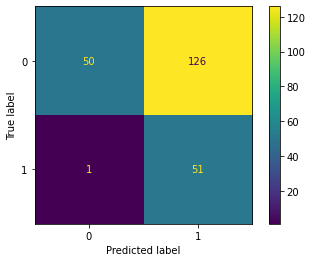

In [12]:
import numpy as np
from util import print_evaluation
prediction = np.vectorize(contains_adj)(test_x)
print_evaluation(test_y, prediction)

Strangely, there are a lot of false positives, let’s check some of them:

In [13]:
# False positives
prediction = train_x.apply(contains_adj)
train_x[(prediction != train_y) & (prediction == 1)][:5]

Test      
583   1459    "Gert en James hebben een relatie": nieuwe gas...
733   1834    "Zo ga ik beroemd worden": cliniclown Kevin (3...
708   1770    Whitney Houston als kind misbruikt door zus be...
741   1855    Temptation' Chloë dumpt Kevin na twee maanden ...
3     4       Maandag drukste dag van het jaar op Brussels A...
Name: Headline, dtype: object

Hmm, all of those actually contain adjectives. I managed to find a better description in the paper:
> Bij het analyseren voor dit onderdeel focusten we op  specifieke, veelzeggende adjectieven die enkel in de ene kop van de test gebruikt werden en niet in de andere (bv.‘Internethype 'uit rijdende auto springen en  dansje  doen'  loopt  uit  de  hand’ tegenover ‘Levensgevaarlijkeinternethype  waait  over  uit  VS’).

So it must be adjectives that are "veelzeggend" and not in the other headline. We're currently seeing each sentence completely seperately, so SpaCy isn't really useful here. In the the negative example, there is also an adjective "nieuwe".